In [1]:
from torchvision.datasets import FashionMNIST
from tsv.natvamp import ModularNVPW
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns

fmnist_train = FashionMNIST(
    "FMNIST",
    train=True,
    download=True,
)
control_data = fmnist_train.data.view(-1, 1, 28, 28).float().numpy()
control_data /= 255
control_labels = fmnist_train.targets.numpy()

/home/zain/micromamba/envs/tsv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ModularNVPW.load_from_checkpoint("/home/zain/code/two-stage/logs/nvpw/fmnist-pseudodiverge/checkpoints/epoch=99-step=5900.ckpt")
torch.set_grad_enabled(False)

Initializing scale_blocks.0.blocks.0.conv_modules.0.weight as a convolutional layer
Initializing scale_blocks.0.blocks.0.conv_modules.0.bias as a bias
Initializing scale_blocks.0.blocks.0.conv_modules.1.weight as a convolutional layer
Initializing scale_blocks.0.blocks.0.conv_modules.1.bias as a bias
Initializing scale_blocks.0.blocks.0.conv_modules.2.weight as a convolutional layer
Initializing scale_blocks.0.blocks.0.conv_modules.2.bias as a bias
Initializing scale_blocks.0.blocks.0.batch_norms.0.bias as a bias
Initializing scale_blocks.0.blocks.0.batch_norms.1.bias as a bias
Initializing scale_blocks.0.blocks.0.batch_norms.2.bias as a bias
Initializing scale_blocks.0.blocks.0.bypass_conv.weight as a convolutional layer
Initializing scale_blocks.0.blocks.0.bypass_conv.bias as a bias
Initializing scale_blocks.0.blocks.0.bypass_batch_norm.bias as a bias
Initializing scale_blocks.0.blocks.1.conv_modules.0.weight as a convolutional layer
Initializing scale_blocks.0.blocks.1.conv_modules.

In [3]:
model.eval().cuda()

ModularNVPW(
  (encoder): ResnetEncoder(
    (scale_blocks): ModuleList(
      (0): ScaleBlock(
        (blocks): ModuleList(
          (0): ResidualConv(
            (conv_modules): ModuleList(
              (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
              (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
              (2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
            )
            (activation_funcs): ModuleList(
              (0-1): 2 x LeakyReLU(negative_slope=0.01)
              (2): Identity()
            )
            (batch_norms): ModuleList(
              (0): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
              (1-2): 2 x LayerNorm((64, 28, 28), eps=1e-05, elementwise_affine=True)
            )
            (bypass_activation_func): LeakyReLU(negative_slope=0.01)
            (bypass_conv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
            (bypass_batc

In [4]:
def plot_pseudos_and_representatives(pseudos, representatives):

    fig, axs = plt.subplots(
        pseudos.shape[0], representatives.shape[0] + 1, figsize=(8, 28)
    )
    print(representatives.shape)
    for i, ax in enumerate(axs):
        pseudo = pseudos[i, 0]
        ax[0].imshow(pseudo)
        ax[0].axis("off")
        for j in range(1, representatives.shape[0] + 1):
            rep = representatives[j - 1, i]
            ax[j].imshow(rep)
            ax[j].axis("off")
    fig.tight_layout()
    fig.show()

In [5]:
def plot_pseudos():
    width = np.ceil(np.sqrt(model.num_pseudos))
    width = int(width)
    length = width
    if model.num_pseudos % width == 0:
        length = model.num_pseudos // width
    fig, ax = plt.subplots(length, width, figsize=(14, 10))

    for i, _ax in zip(range(model.num_pseudos), ax.flatten()):
        pseudo = model.pseudos[i].cpu().view(28, 28).numpy()
        _ax.imshow(pseudo)
    fig.show()

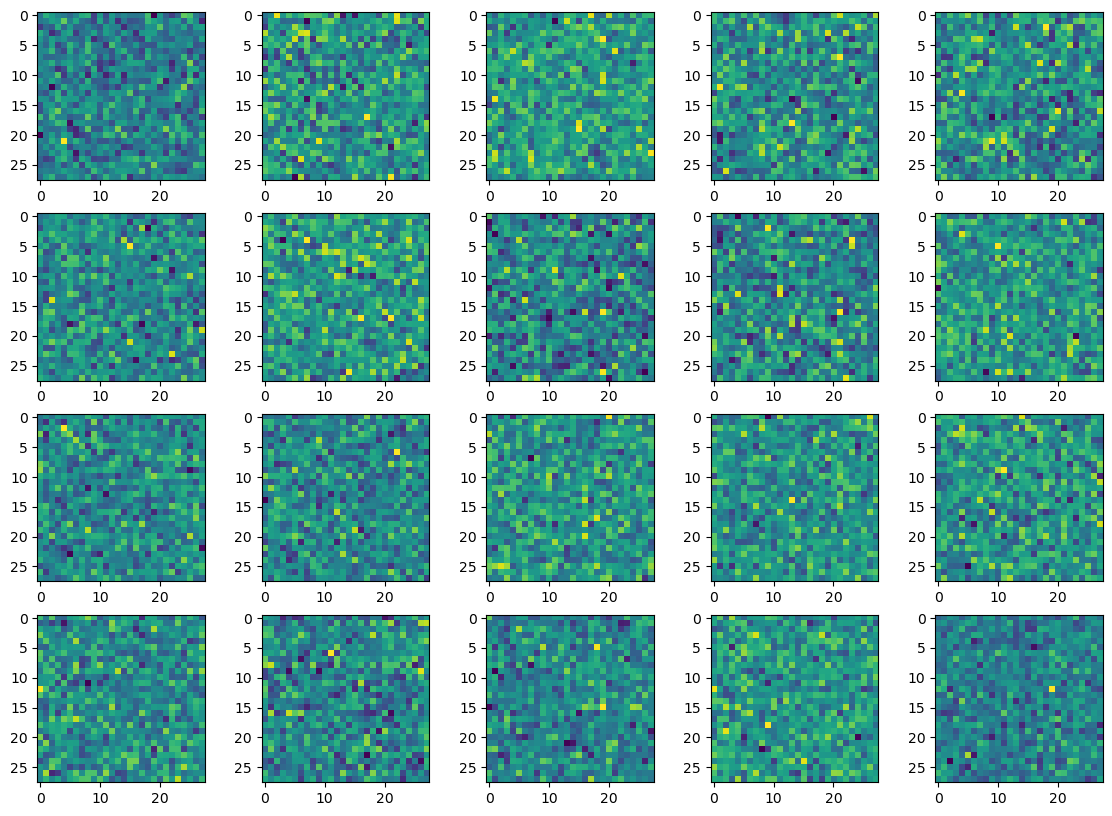

In [6]:
plot_pseudos()

In [7]:
model.project_pseudos()

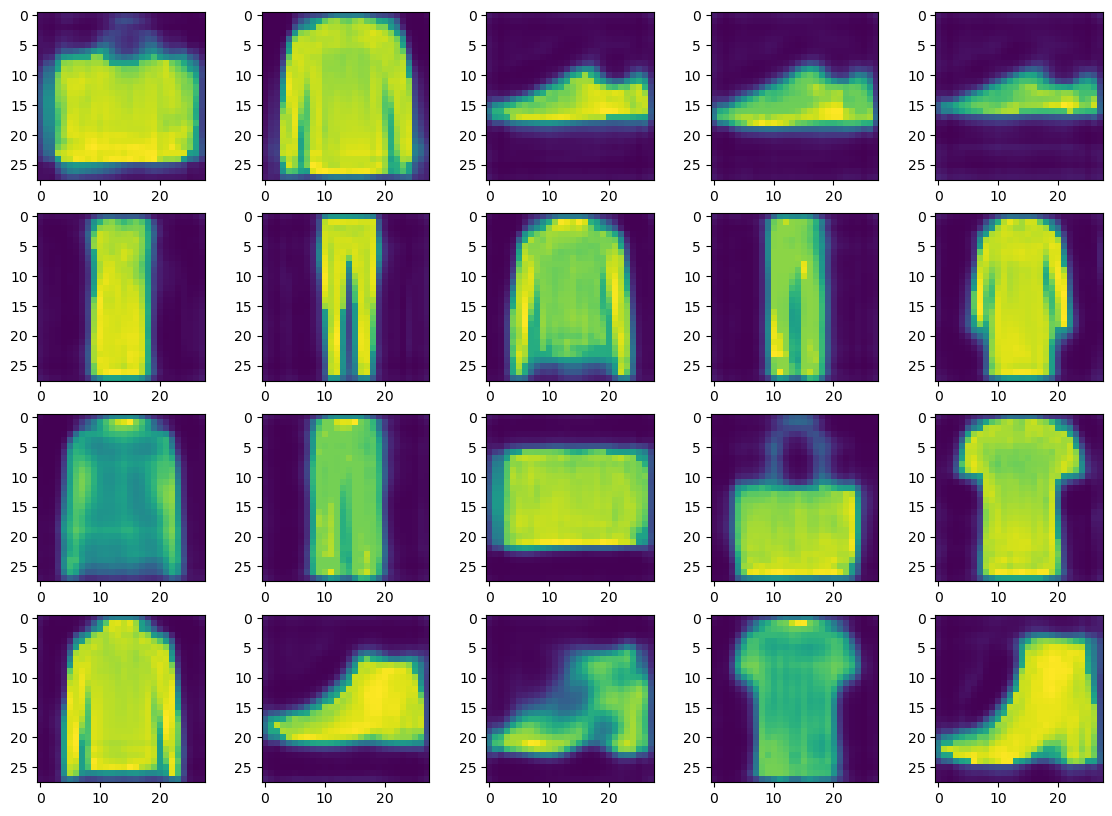

In [8]:
plot_pseudos()

In [9]:
def calculate_divergences(model, indices):
    divergences = np.full((len(indices), len(indices)), np.inf)
    for idx, jdx in product(indices, indices):
        if idx == jdx:
            continue
        x, y = model.get_pseudos()[[idx, jdx]]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
        kl_div = model.general_kl(*model.q_z(x)[:2], *model.q_z(y)[:2])
        divergences[idx, jdx] = kl_div.item()
    return divergences

In [10]:
def _find_twins(divergences_triplet):
    twins = []
    for idx, jdx in divergences_triplet:
        if (jdx, idx) in twins or (idx, jdx) in twins:
            continue
        if (jdx, idx) in divergences_triplet:
            if jdx < idx:
                idx, jdx = jdx, idx
            twins.append((idx, jdx))
    return twins

In [11]:
def propose_merges(model):
    divergences = calculate_divergences(model, range(model.num_pseudos))
    sorted_divergences = np.argmin(divergences, axis=1)
    twin_idxs = np.argsort(divergences[np.arange(divergences.shape[0]), sorted_divergences])    
    divergences_triplet = {}
    for idx in twin_idxs:
        divergences_triplet[(idx, sorted_divergences[idx])] = divergences[idx, sorted_divergences[idx]]
    twins = _find_twins(divergences_triplet)
    sorted_twins = sorted(twins, reverse=True, key=lambda x: x[1])
    return sorted_twins

In [29]:
merges = propose_merges(model)

In [ ]:
model.merge_pseudos(merges)

Merging 14 and 18
Merging 16 and 17
Merging 7 and 15
Merging 6 and 8
Merging 2 and 3


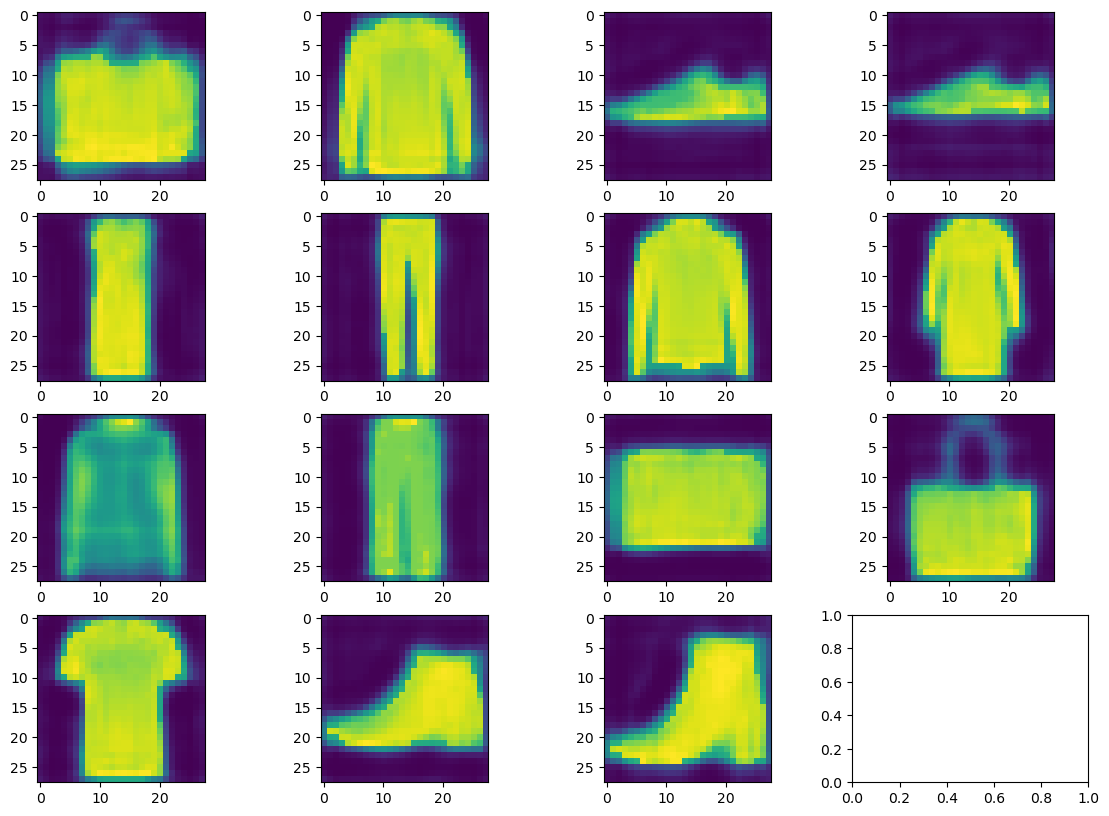

In [18]:
plot_pseudos()

In [19]:
divergences = calculate_divergences(model, range(model.num_pseudos))
sorted_divergences = sorted(divergences, key=lambda x: x[2])

In [20]:
# torch.save(model, "/home/zain/code/two-stage/logs/nvpw/fmnist-pseudodiverge/model.pt")

In [21]:
from torch.utils.data import DataLoader
import tqdm
data_loader = DataLoader(
            fmnist_train.train_data,
            batch_size=256,
            num_workers=4,
            shuffle=False,
            persistent_workers=False,
            pin_memory=True,
            prefetch_factor=5,
        )


/home/zain/micromamba/envs/tsv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [22]:
from tsv.natvamp import log_normal_diag

pseudos = model.get_pseudos()
mu_p, logvar_p, *_ = model.q_z(pseudos)
max_likelihood_idx = []
likelihoods = []
for batch in tqdm.tqdm(data_loader):
    x = batch.float().cuda().view(-1, 1, 28, 28)
    x /= 255
    mu = model.q_z(x)[0]
    likelihoods.append(log_normal_diag(mu.unsqueeze(1), mu_p.unsqueeze(0), logvar_p.unsqueeze(0), reduction="sum", dim=-1).cpu())
likelihoods = torch.cat(likelihoods, 0)
max_likelihood_idx = likelihoods.argmax(1).cpu().numpy()


100%|██████████| 235/235 [00:04<00:00, 55.18it/s]


In [23]:
def find_representatives(pseudo_idx, num_representatives):
    base_idx = np.arange(likelihoods.shape[0])
    paragon_mask = max_likelihood_idx == pseudo_idx
    base_idx = base_idx[paragon_mask]
    paragon_likelihoods = likelihoods[paragon_mask, pseudo_idx]
    vals, indices = torch.sort(paragon_likelihoods.cpu(), descending=True)
    representatives = base_idx[indices][:num_representatives]
    return representatives

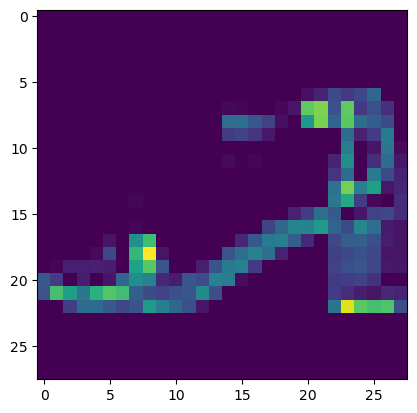

In [24]:
idx = 0
plt.imshow(control_data[find_representatives(0, 3)[idx]][0])

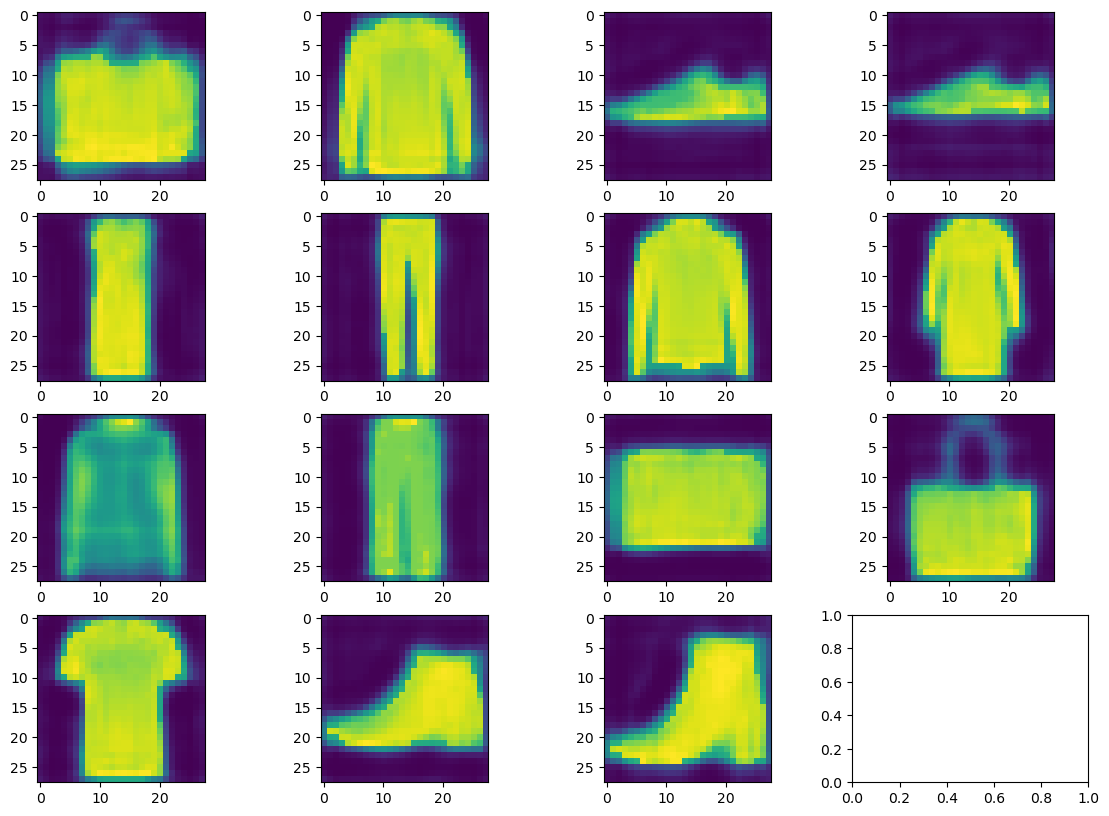

In [25]:
plot_pseudos()

In [26]:
representatives = torch.cat(
    [torch.tensor(control_data[find_representatives(i, 3)]) for i in range(model.num_pseudos)], 1
)

In [27]:
representatives.shape

torch.Size([3, 15, 28, 28])

torch.Size([3, 15, 28, 28])


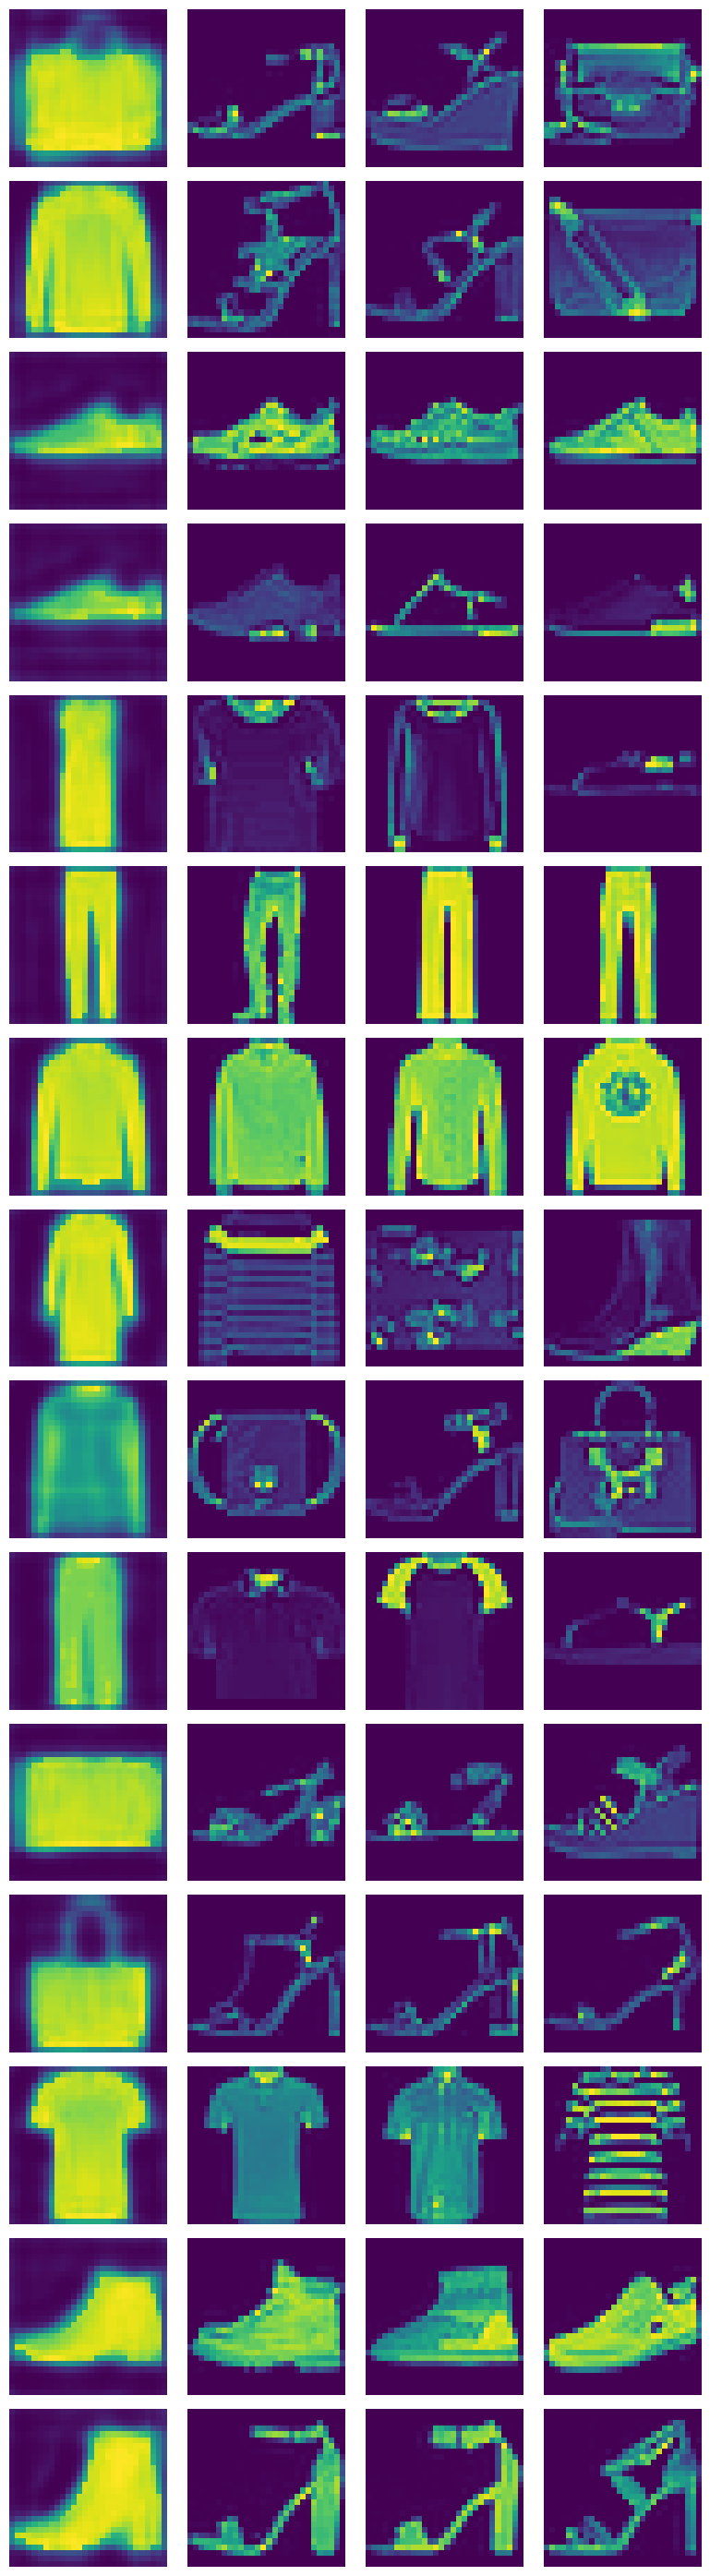

In [28]:
plot_pseudos_and_representatives(pseudos.cpu(), representatives.cpu())